In [ ]:
#Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import time

#Sklearn
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from tabulate import tabulate

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# Data Processing

In [ ]:
rates = pd.read_csv('US_FRED_data_1970_2020.csv', header=0, index_col=0, parse_dates=False, infer_datetime_format=True)
rates.index.name = ""
tran_code = pd.read_csv('US_FRED_data_transform_code.csv', header=0, index_col=0, parse_dates=False)
tran_code.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Symbol,,,,,,,,,,,,,,,,,,,,,
Tran_code,5,5,5,5,5,5,5,5,5,5,...,6,6,6,6,6,6,6,6,6,1


In [ ]:
def data_transform(x, tran_code):

    if tran_code == 1:
        x_tr = x

    elif tran_code == 2:
        x_tr = x.diff()

    elif tran_code == 3:
        x_tr = x.diff().diff()

    elif tran_code == 4:
        x_tr = np.log(x)

    elif tran_code == 5:
        x_tr = np.log(x).diff()*100

    else :
        x_tr = np.log(x).diff().diff()*100

    return x_tr
rates_tr = []

for col in rates.columns:
    tr_code = tran_code[col].values
    data_tr = data_transform(rates[col], tr_code)
    rates_tr.append(data_tr)

rates_tr = pd.DataFrame(rates_tr).T
rates_tr

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
,,,,,,,,,,,,,,,,,,,,,
1/1/1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.2759
2/1/1970,0.246947,0.177953,0.438440,0.088842,0.465422,-0.065863,0.268485,0.515531,0.982275,1.447760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6779
3/1/1970,0.386306,0.376110,-0.510499,-1.175414,-0.939622,-0.129755,-0.053489,-0.266519,-0.119781,0.945382,...,-0.458412,0.017239,-0.297086,0.433807,0.312977,0.767396,0.243123,-0.271828,2.857575,17.4539
4/1/1970,0.988698,-0.591286,0.075661,-0.506701,1.178048,-0.257644,0.033747,-0.025445,0.404196,-0.046166,...,0.697516,0.036106,-0.003361,0.422546,-0.628933,0.106014,1.155765,0.762551,0.395842,18.3914
5/1/1970,-0.576055,0.209869,0.685536,1.080291,1.418739,-0.116539,0.030237,0.053738,0.541210,0.098734,...,-0.461442,-0.065881,-0.290266,-1.726023,0.936044,0.282581,-0.360361,-0.160888,-1.934758,37.6526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8/1/2020,-3.279001,1.042881,0.683643,0.212971,0.811046,1.052210,1.303505,1.257238,0.746547,-0.975054,...,-0.041113,0.016066,-0.275567,0.340820,-0.836629,-0.245214,-0.567483,-0.265594,-1.578047,20.2777
9/1/2020,0.566616,0.988428,1.312524,0.604530,2.000114,-0.303404,-0.573260,-1.012366,-1.489310,-1.347569,...,-0.370246,0.057291,-0.196102,-1.332697,0.479027,0.672130,-0.146940,0.220884,-0.139709,28.3241
10/1/2020,-0.271682,1.377340,0.409096,0.975145,0.092764,1.085592,1.073259,0.663889,0.276764,0.880885,...,0.057657,-0.193957,0.430889,2.086021,-0.697246,-0.269003,-0.859634,-0.596307,0.228057,30.9408


In [ ]:
rates_tr["FEDFUNDS"]


1/1/1970      NaN
2/1/1970     0.00
3/1/1970    -1.22
4/1/1970     0.34
5/1/1970    -0.15
             ... 
8/1/2020     0.01
9/1/2020    -0.01
10/1/2020    0.00
11/1/2020    0.00
12/1/2020    0.00
Name: FEDFUNDS, Length: 612, dtype: float64

In [ ]:
X_start = 1
X_lag = 1
X = rates_tr.iloc[X_start:].shift(X_lag).dropna().drop(['FEDFUNDS'],axis = 1)
y = rates_tr.iloc[X_start:].dropna().iloc[X_lag:]['FEDFUNDS']
X

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
,,,,,,,,,,,,,,,,,,,,,
4/1/1970,0.386306,0.376110,-0.510499,-1.175414,-0.939622,-0.129755,-0.053489,-0.266519,-0.119781,0.945382,...,-0.458412,0.017239,-0.297086,0.433807,0.312977,0.767396,0.243123,-0.271828,2.857575,17.4539
5/1/1970,0.988698,-0.591286,0.075661,-0.506701,1.178048,-0.257644,0.033747,-0.025445,0.404196,-0.046166,...,0.697516,0.036106,-0.003361,0.422546,-0.628933,0.106014,1.155765,0.762551,0.395842,18.3914
6/1/1970,-0.576055,0.209869,0.685536,1.080291,1.418739,-0.116539,0.030237,0.053738,0.541210,0.098734,...,-0.461442,-0.065881,-0.290266,-1.726023,0.936044,0.282581,-0.360361,-0.160888,-1.934758,37.6526
7/1/1970,0.311838,0.323239,0.335667,0.399715,0.634801,-0.323964,-0.234641,-0.213303,0.250222,1.921268,...,-0.124762,-0.014493,0.570604,1.714922,-0.316847,0.327742,0.465830,0.758026,0.429053,23.7760
8/1/1970,0.559793,0.527650,-0.021392,0.106662,0.833842,0.245315,0.087117,-0.106692,0.239641,0.178562,...,0.243732,-0.014320,-0.290191,-0.016298,-0.311030,0.174020,-3.447940,-1.827710,0.935810,21.3723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8/1/2020,0.598813,0.991831,1.432611,2.601717,1.439484,4.006429,4.254453,4.738868,4.180368,15.062340,...,-0.747237,-0.031421,0.432630,-1.166406,1.584905,-0.705023,-0.621750,0.056104,-0.287128,24.3785
9/1/2020,-3.279001,1.042881,0.683643,0.212971,0.811046,1.052210,1.303505,1.257238,0.746547,-0.975054,...,-0.041113,0.016066,-0.275567,0.340820,-0.836629,-0.245214,-0.567483,-0.265594,-1.578047,20.2777
10/1/2020,0.566616,0.988428,1.312524,0.604530,2.000114,-0.303404,-0.573260,-1.012366,-1.489310,-1.347569,...,-0.370246,0.057291,-0.196102,-1.332697,0.479027,0.672130,-0.146940,0.220884,-0.139709,28.3241


In [ ]:
y


4/1/1970     0.34
5/1/1970    -0.15
6/1/1970    -0.34
7/1/1970    -0.40
8/1/1970    -0.59
             ... 
8/1/2020     0.01
9/1/2020    -0.01
10/1/2020    0.00
11/1/2020    0.00
12/1/2020    0.00
Name: FEDFUNDS, Length: 596, dtype: float64

#PCA + Linear Regression + Ridge Regression + Lasso Regression + Elastic Net Regression (with 80% of data in training set for rolling window)

In [ ]:
steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('pca', PCA(n_components = 1, random_state=1))]

pl_pca_X = Pipeline(steps_X)

X_pca_model = pl_pca_X.fit(X)

print('n_components:', 1, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

X_pca = X_pca_model.transform(X)

n_components: 1    variance explained: 0.210


In [ ]:
for n_comp in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,124]:

    steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = n_comp, random_state=1))]

    pl_pca_X = Pipeline(steps_X)
    X_pca_model = pl_pca_X.fit(X)

    print('n_components:', n_comp, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

n_components: 1    variance explained: 0.210
n_components: 2    variance explained: 0.287
n_components: 3    variance explained: 0.357
n_components: 4    variance explained: 0.414
n_components: 5    variance explained: 0.468
n_components: 6    variance explained: 0.504
n_components: 7    variance explained: 0.532
n_components: 8    variance explained: 0.556
n_components: 9    variance explained: 0.579
n_components: 10    variance explained: 0.600
n_components: 11    variance explained: 0.620
n_components: 12    variance explained: 0.637
n_components: 13    variance explained: 0.654
n_components: 14    variance explained: 0.669
n_components: 15    variance explained: 0.683
n_components: 16    variance explained: 0.698
n_components: 17    variance explained: 0.711
n_components: 18    variance explained: 0.723
n_components: 19    variance explained: 0.735
n_components: 20    variance explained: 0.747
n_components: 30    variance explained: 0.833
n_components: 50    variance explained: 0.9

In [ ]:
n_train = 477   # 2013-M12
n_records = len(X)
n_forecast = n_records - n_train

j = 0
for i in range(n_train, n_records):
    #train, test = X[0:i], X[i:i+1]   #expanding window
    train, test = X[j:i], X[i:i+1]   #rolling window (constant size of window)
    print('train=%d, test=%d' % (len(train), len(test)))
    j += 1

train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477, test=1
train=477,

In [ ]:
#Grid search for optimal hyperparameters
def pipeline(config):

    # unpack config
    n_comps = config

    # Steps
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('ols', LinearRegression())
            ]

    pipeline = Pipeline(steps)

    return pipeline

def walk_forward_validation(cfg):
    global X_train

    n_train = 477

    n_records = len(X)

    y_test_list = []

    y_pred_list = []

    j = 0

    for i in range(n_train, n_records):

        X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_pred_list.extend(y_pred)

        y_test_list.extend(y_test)

        j += 1

    score_rmse = metrics.mean_squared_error(y_test_list, y_pred_list, squared=False)

    print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config, n_repeats=1):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(config) for _ in range(n_repeats)]
    # summarize score
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    # evaluate configs
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    # sort configs by score_rmse, asc
    #scores.sort(key=lambda tup: tup[1])
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    # define scope of configs

    n_comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30]
    #n_comps = [10]

    # create configs
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

In [ ]:
cfg_list = model_configs()

Total configs: 18


In [ ]:
cfg_list = model_configs()
scores = grid_search(cfg_list)
print('done')

Total configs: 18
 > 0.765
> Model[1] 0.765
 > 0.770
> Model[2] 0.770
 > 0.772
> Model[3] 0.772
 > 0.683
> Model[4] 0.683
 > 0.655
> Model[5] 0.655
 > 0.411
> Model[6] 0.411
 > 0.507
> Model[7] 0.507
 > 0.460
> Model[8] 0.460
 > 0.407
> Model[9] 0.407
 > 0.427
> Model[10] 0.427
 > 0.301
> Model[11] 0.301
 > 0.300
> Model[12] 0.300
 > 0.281
> Model[13] 0.281
 > 0.294
> Model[14] 0.294
 > 0.290
> Model[15] 0.290
 > 0.311
> Model[20] 0.311
 > 0.267
> Model[25] 0.267
 > 0.220
> Model[30] 0.220
done


In [ ]:
scores

[('3', 0.7717518206047582),
 ('2', 0.7696307995509944),
 ('1', 0.7645392787201905),
 ('4', 0.6825857209838214),
 ('5', 0.6553749454529885),
 ('7', 0.5069057879453),
 ('8', 0.4595674503734454),
 ('10', 0.4274737849212689),
 ('6', 0.41111266775387195),
 ('9', 0.4073433608156499),
 ('20', 0.3114831985202225),
 ('11', 0.3006604914828527),
 ('12', 0.2996685351636805),
 ('14', 0.2936385355549428),
 ('15', 0.28958315651491295),
 ('13', 0.28126630789323365),
 ('25', 0.26650679059050214),
 ('30', 0.22019421921874804)]

In [ ]:
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 30, random_state=1)),
               ('ols', LinearRegression())
              ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 477

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 3.6146838665008545


In [ ]:
pd.options.display.max_rows=300
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
2/1/2011,-0.01,0.285394
3/1/2011,-0.02,0.169616
4/1/2011,-0.04,-0.016639
5/1/2011,-0.01,0.141969
6/1/2011,0.00,-0.106887
7/1/2011,-0.02,-0.202031
8/1/2011,0.03,0.313653
9/1/2011,-0.02,-0.421170
10/1/2011,-0.01,-0.445604


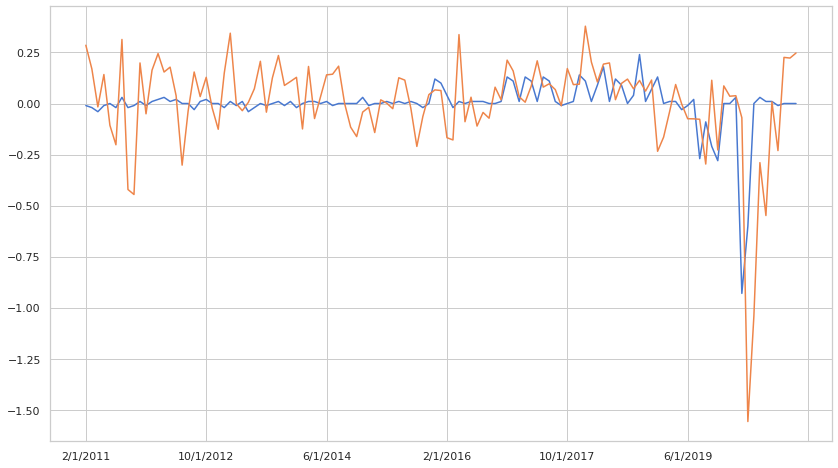

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

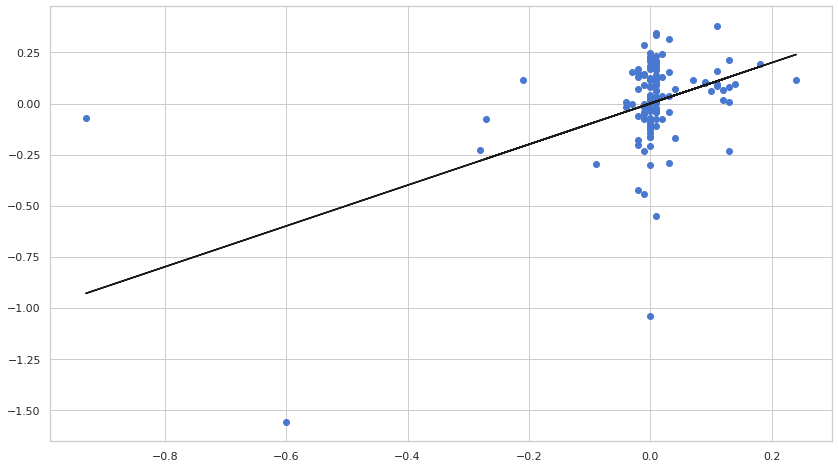

In [ ]:
plt.scatter(y_test_list, y_pred_list)
plt.plot(y_test_list, y_test_list,'k-')

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.000000,0.389973
Fed_Funds_Predicted,0.389973,1.000000


In [ ]:
mae_lin = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_lin = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_lin)
print(rmse_lin)

Test set evaluation:
_____________________________________
0.14402101000110507
0.22019421921874804


In [ ]:
#With Ridge Regression
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 30, random_state=1)),
               ('ols', Ridge(alpha = 1000))
              ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 477

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 3.6624515056610107


In [ ]:
pd.options.display.max_rows=300
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
2/1/2011,-0.01,0.155512
3/1/2011,-0.02,0.081777
4/1/2011,-0.04,-0.011540
5/1/2011,-0.01,0.005317
6/1/2011,0.00,-0.112396
7/1/2011,-0.02,-0.157514
8/1/2011,0.03,0.164232
9/1/2011,-0.02,-0.349238
10/1/2011,-0.01,-0.236238


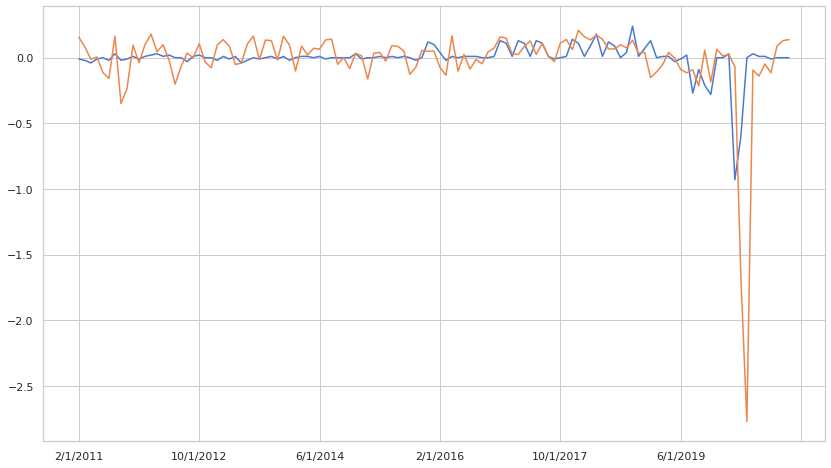

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.00000,0.30136
Fed_Funds_Predicted,0.30136,1.00000


In [ ]:
mae_ridge = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_ridge = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_ridge)
print(rmse_ridge)

Test set evaluation:
_____________________________________
0.12130786925463463
0.3014858849687088


In [ ]:
#With Lasso Regression
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 30, random_state=1)),
               ('ols', Lasso(alpha = 30000))
              ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 477

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 3.927063465118408


In [ ]:
pd.options.display.max_rows=488
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
2/1/2011,-0.01,-0.007338
3/1/2011,-0.02,-0.008071
4/1/2011,-0.04,-0.007799
5/1/2011,-0.01,-0.007170
6/1/2011,0.00,-0.006352
7/1/2011,-0.02,-0.005115
8/1/2011,0.03,-0.004465
9/1/2011,-0.02,-0.004214
10/1/2011,-0.01,-0.002998


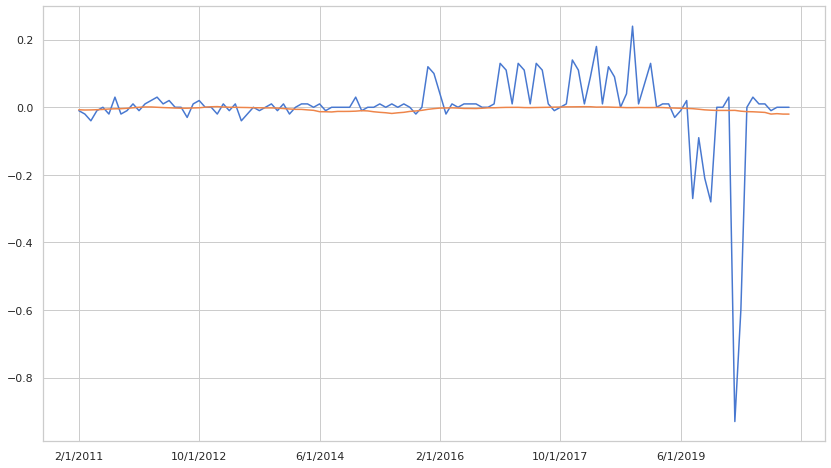

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.000000,0.223285
Fed_Funds_Predicted,0.223285,1.000000


In [ ]:
mae_lasso = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_lasso = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_lasso)
print(rmse_lasso)

Test set evaluation:
_____________________________________
0.048978736148547475
0.11968702734572367


In [ ]:
#With Elastic Net
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 30, random_state=1)),
               ('ols', ElasticNet(alpha=100, l1_ratio=0.5, max_iter=30000))]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 477

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 3.2054998874664307


In [ ]:
pd.options.display.max_rows=300
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
2/1/2011,-0.01,-0.007338
3/1/2011,-0.02,-0.008071
4/1/2011,-0.04,-0.007799
5/1/2011,-0.01,-0.007170
6/1/2011,0.00,-0.006352
7/1/2011,-0.02,-0.005115
8/1/2011,0.03,-0.004465
9/1/2011,-0.02,-0.004214
10/1/2011,-0.01,-0.002998


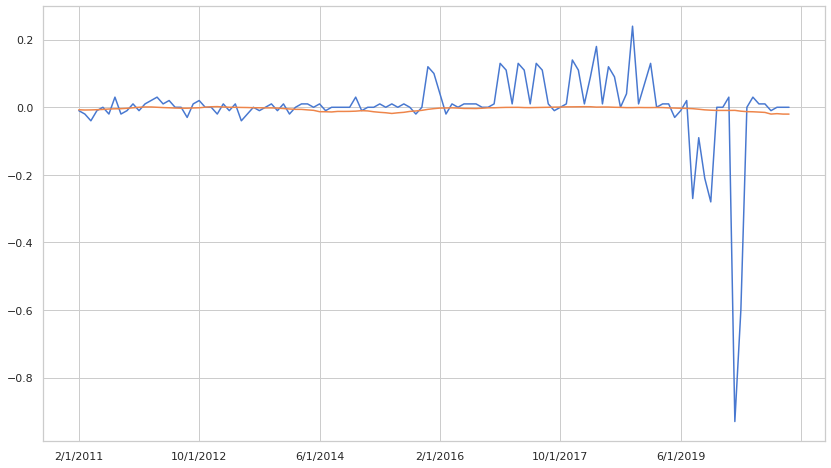

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.000000,0.223285
Fed_Funds_Predicted,0.223285,1.000000


In [ ]:
mae_elasticnet = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_elasticnet = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_elasticnet)
print(rmse_elasticnet)

Test set evaluation:
_____________________________________
0.048978736148547475
0.11968702734572367


In [ ]:
final_result =  pd.DataFrame({"MAE": [mae_lin, mae_ridge, mae_lasso, mae_elasticnet],
                             "RMSE": [rmse_lin,rmse_ridge,rmse_lasso,rmse_elasticnet],
                             })
final_result.index = ["lin_reg","Ridge","Lasso","Elastic Net"]
final_result

,MAE,RMSE
lin_reg,0.144021,0.220194
Ridge,0.121308,0.301486
Lasso,0.048979,0.119687
Elastic Net,0.048979,0.119687


# PCA + Linear Regression + Ridge Regression + Lasso Regression + Elastic Net Regression (with 70% of data in training set for rolling window)

In [ ]:
steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('pca', PCA(n_components = 1, random_state=1))]

pl_pca_X = Pipeline(steps_X)

X_pca_model = pl_pca_X.fit(X)

print('n_components:', 1, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

X_pca = X_pca_model.transform(X)

n_components: 1    variance explained: 0.210


In [ ]:
for n_comp in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,124]:

    steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = n_comp, random_state=1))]

    pl_pca_X = Pipeline(steps_X)
    X_pca_model = pl_pca_X.fit(X)

    print('n_components:', n_comp, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

n_components: 1    variance explained: 0.210
n_components: 2    variance explained: 0.287
n_components: 3    variance explained: 0.357
n_components: 4    variance explained: 0.414
n_components: 5    variance explained: 0.468
n_components: 6    variance explained: 0.504
n_components: 7    variance explained: 0.532
n_components: 8    variance explained: 0.556
n_components: 9    variance explained: 0.579
n_components: 10    variance explained: 0.600
n_components: 11    variance explained: 0.620
n_components: 12    variance explained: 0.637
n_components: 13    variance explained: 0.654
n_components: 14    variance explained: 0.669
n_components: 15    variance explained: 0.683
n_components: 16    variance explained: 0.698
n_components: 17    variance explained: 0.711
n_components: 18    variance explained: 0.723
n_components: 19    variance explained: 0.735
n_components: 20    variance explained: 0.747
n_components: 30    variance explained: 0.833
n_components: 50    variance explained: 0.9

In [ ]:
n_train = 417   # 2013-M12
n_records = len(X)
n_forecast = n_records - n_train

j = 0
for i in range(n_train, n_records):
    #train, test = X[0:i], X[i:i+1]   #expanding window
    train, test = X[j:i], X[i:i+1]   #rolling window (constant size of window)
    print('train=%d, test=%d' % (len(train), len(test)))
    j += 1

train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417, test=1
train=417,

In [ ]:
#Grid search for optimal hyperparameters
def pipeline(config):

    # unpack config
    n_comps = config

    # Steps
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('ols', LinearRegression())
            ]

    pipeline = Pipeline(steps)

    return pipeline

def walk_forward_validation(cfg):
    global X_train

    n_train = 417

    n_records = len(X)

    y_test_list = []

    y_pred_list = []

    j = 0

    for i in range(n_train, n_records):

        X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_pred_list.extend(y_pred)

        y_test_list.extend(y_test)

        j += 1

    score_rmse = metrics.mean_squared_error(y_test_list, y_pred_list, squared=False)

    print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config, n_repeats=1):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(config) for _ in range(n_repeats)]
    # summarize score
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    # evaluate configs
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    # sort configs by score_rmse, asc
    #scores.sort(key=lambda tup: tup[1])
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    # define scope of configs

    n_comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30]
    #n_comps = [10]

    # create configs
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

In [ ]:
cfg_list = model_configs()

Total configs: 18


In [ ]:
cfg_list = model_configs()
scores = grid_search(cfg_list)
print('done')

Total configs: 18
 > 0.339
> Model[1] 0.339
 > 0.341
> Model[2] 0.341
 > 0.343
> Model[3] 0.343
 > 0.346
> Model[4] 0.346
 > 0.257
> Model[5] 0.257
 > 0.270
> Model[6] 0.270
 > 0.274
> Model[7] 0.274
 > 0.269
> Model[8] 0.269
 > 0.262
> Model[9] 0.262
 > 0.209
> Model[10] 0.209
 > 0.187
> Model[11] 0.187
 > 0.191
> Model[12] 0.191
 > 0.192
> Model[13] 0.192
 > 0.193
> Model[14] 0.193
 > 0.194
> Model[15] 0.194
 > 0.204
> Model[20] 0.204
 > 0.211
> Model[25] 0.211
 > 0.216
> Model[30] 0.216
done


In [ ]:
scores

[('4', 0.34634956161140507),
 ('3', 0.3434661465813671),
 ('2', 0.3412608199280134),
 ('1', 0.33895976277057666),
 ('7', 0.27423790835511264),
 ('6', 0.2701664113484961),
 ('8', 0.26939566374907065),
 ('9', 0.2621440566753913),
 ('5', 0.2566810230186158),
 ('30', 0.21568978288262725),
 ('25', 0.21067635492312753),
 ('10', 0.20917391678390543),
 ('20', 0.2038882593564707),
 ('15', 0.19385226245587844),
 ('14', 0.1934910749289093),
 ('13', 0.19178679800575746),
 ('12', 0.191322567059909),
 ('11', 0.18655268245620008)]

In [ ]:
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 11, random_state=1)),
               ('ols', LinearRegression())
              ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 417

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 5.080492734909058


In [ ]:
pd.options.display.max_rows=300
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
1/1/2005,0.12,0.255187
2/1/2005,0.22,0.146968
3/1/2005,0.13,0.247754
4/1/2005,0.16,0.372442
5/1/2005,0.21,0.064079
6/1/2005,0.04,0.063587
7/1/2005,0.22,0.255261
8/1/2005,0.24,0.418642
9/1/2005,0.12,0.234371


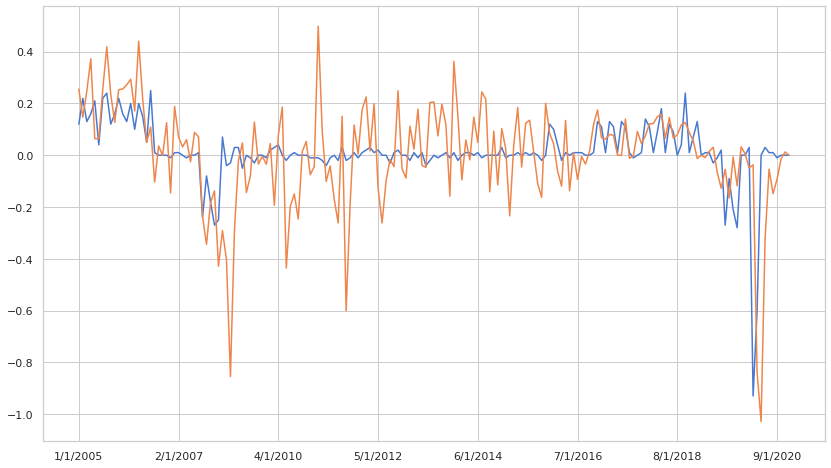

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

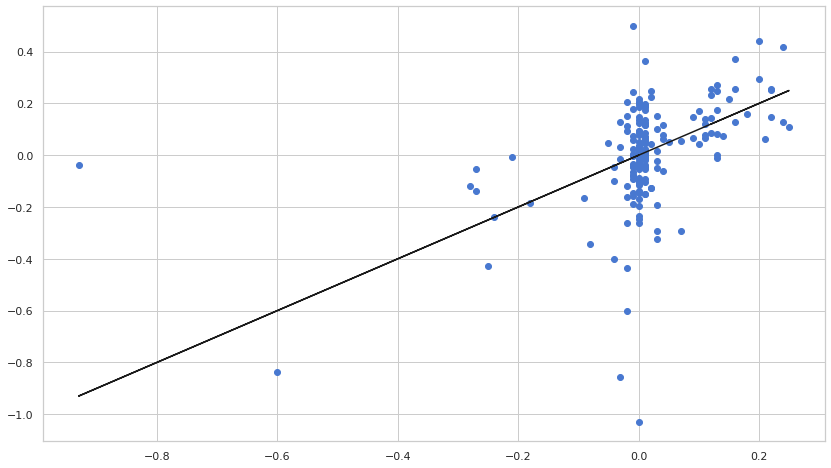

In [ ]:
plt.scatter(y_test_list, y_pred_list)
plt.plot(y_test_list, y_test_list,'k-')

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.000000,0.425168
Fed_Funds_Predicted,0.425168,1.000000


In [ ]:
mae_lin = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_lin = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_lin)
print(rmse_lin)

Test set evaluation:
_____________________________________
0.12151821576129651
0.18655268245620008


In [ ]:
#With Ridge Regression
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 11, random_state=1)),
               ('ols', Ridge(alpha = 1000))
              ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 417

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 4.73590874671936


In [ ]:
pd.options.display.max_rows=300
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
1/1/2005,0.12,0.204793
2/1/2005,0.22,0.111679
3/1/2005,0.13,0.225528
4/1/2005,0.16,0.250202
5/1/2005,0.21,0.089612
6/1/2005,0.04,0.038750
7/1/2005,0.22,0.193958
8/1/2005,0.24,0.312155
9/1/2005,0.12,0.183859


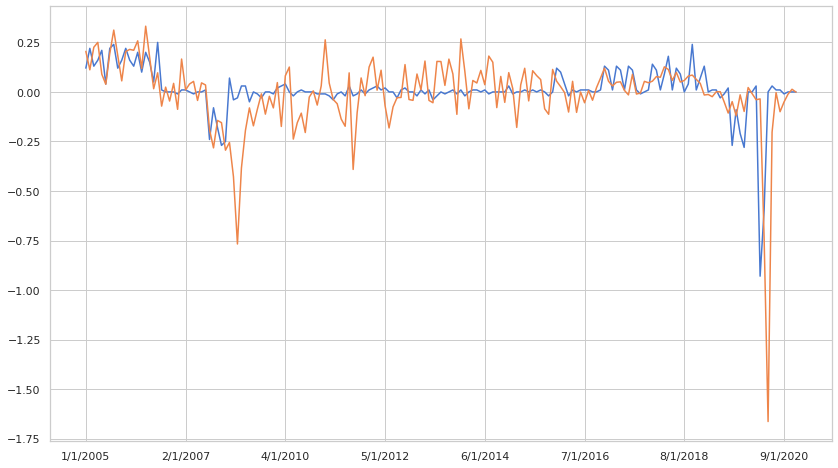

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.000000,0.366336
Fed_Funds_Predicted,0.366336,1.000000


In [ ]:
mae_ridge = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_ridge = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_ridge)
print(rmse_ridge)

Test set evaluation:
_____________________________________
0.09990499848894256
0.18731684656097677


In [ ]:
#With Lasso Regression
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 11, random_state=1)),
               ('ols', Lasso(alpha = 30000))
              ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 417

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 4.861860275268555


In [ ]:
pd.options.display.max_rows=488
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
1/1/2005,0.12,-0.013429
2/1/2005,0.22,-0.013957
3/1/2005,0.13,-0.013070
4/1/2005,0.16,-0.011942
5/1/2005,0.21,-0.010600
6/1/2005,0.04,-0.008681
7/1/2005,0.22,-0.007794
8/1/2005,0.24,-0.007050
9/1/2005,0.12,-0.005036


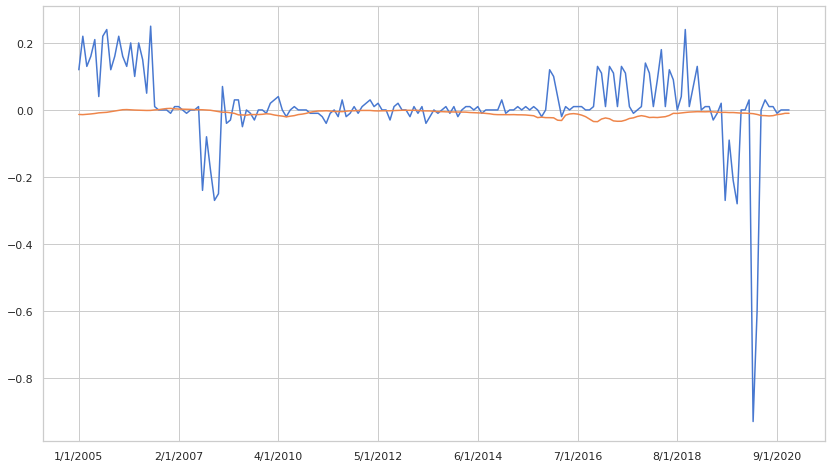

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.000000,-0.091764
Fed_Funds_Predicted,-0.091764,1.000000


In [ ]:
mae_lasso = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_lasso = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_lasso)
print(rmse_lasso)

Test set evaluation:
_____________________________________
0.06351406026017174
0.12184377333868235


In [ ]:
#With Elastic Net
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = 11, random_state=1)),
               ('ols', ElasticNet(alpha=100, l1_ratio=0.5, max_iter=30000))]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 417

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 5.014813423156738


In [ ]:
pd.options.display.max_rows=300
result = pd.DataFrame({'Fed_Funds_Actual': y[-n_forecast:], 'Fed_Funds_Predicted': y_pred_list}, columns=['Fed_Funds_Actual', 'Fed_Funds_Predicted'])
result

,Fed_Funds_Actual,Fed_Funds_Predicted
,,
1/1/2005,0.12,-0.013429
2/1/2005,0.22,-0.013957
3/1/2005,0.13,-0.013070
4/1/2005,0.16,-0.011942
5/1/2005,0.21,-0.010600
6/1/2005,0.04,-0.008681
7/1/2005,0.22,-0.007794
8/1/2005,0.24,-0.007050
9/1/2005,0.12,-0.005036


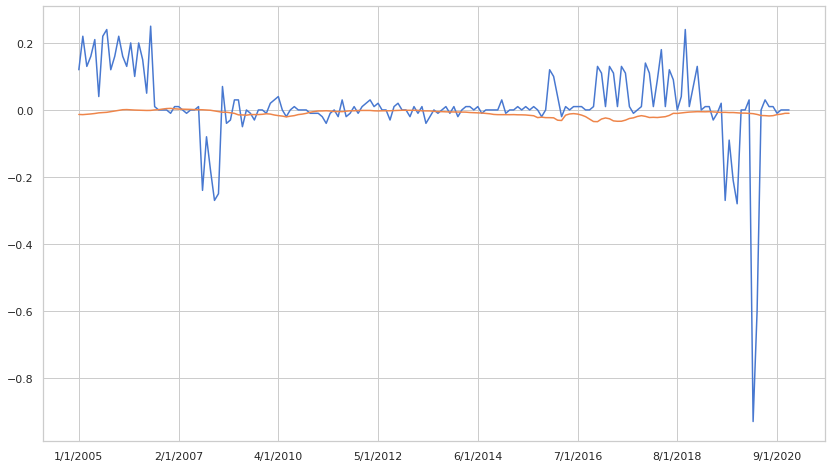

In [ ]:
result['Fed_Funds_Actual'].plot()
result['Fed_Funds_Predicted'].plot()

In [ ]:
result.corr()

,Fed_Funds_Actual,Fed_Funds_Predicted
Fed_Funds_Actual,1.000000,-0.091764
Fed_Funds_Predicted,-0.091764,1.000000


In [ ]:
mae_elasticnet = metrics.mean_absolute_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"])
rmse_elasticnet = np.sqrt(metrics.mean_squared_error(result["Fed_Funds_Actual"],result["Fed_Funds_Predicted"]))
print('Test set evaluation:\n_____________________________________')
print(mae_elasticnet)
print(rmse_elasticnet)

Test set evaluation:
_____________________________________
0.06351406026017174
0.12184377333868235


In [ ]:
final_result =  pd.DataFrame({"MAE": [mae_lin, mae_ridge, mae_lasso, mae_elasticnet],
                             "RMSE": [rmse_lin,rmse_ridge,rmse_lasso,rmse_elasticnet],
                             })
final_result.index = ["Linear","Ridge","Lasso","Elastic Net"]
final_result

,MAE,RMSE
Linear,0.121518,0.186553
Ridge,0.099905,0.187317
Lasso,0.063514,0.121844
Elastic Net,0.063514,0.121844



# Random Forest


In [ ]:
# pipeline
def Random_Forest_pipeline(config):

    # unpack config
    n_trees, n_comps = config

    # Steps
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components=n_comps, random_state=1)),
             ('RandomForest', RandomForestRegressor(n_estimators=n_trees, random_state=1))
            ]

    pipeline = Pipeline(steps)

    return pipeline

In [ ]:
def walk_forward_validation(cfg):

    n_train = 477  #number of observations in the training set

    n_records = len(X)

    y_test_list = []

    y_pred_list = []

    j = 0

    for i in range(n_train, n_records):

        X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1] #each time constant size

        model = Random_Forest_pipeline(cfg).fit(X_train, y_train)     #call pipeline -> train model

        y_pred = model.predict(X_test)

        y_pred_list.extend(y_pred)

        y_test_list.extend(y_test)

        j += 1

    score_rmse = metrics.mean_squared_error(y_test_list, y_pred_list, squared=False)

    print(' > %.3f' % score_rmse)

    return score_rmse

In [ ]:
# score a model, return None on failure
def repeat_evaluate(config, n_repeats=1):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(config) for _ in range(n_repeats)]
    # summarize score
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

In [ ]:
# grid search configs
def grid_search(cfg_list):
    # evaluate configs
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    # sort configs by score_acc, asc
    scores.sort(key=lambda tup: tup[1], reverse =True)
    return scores

In [ ]:
# create a list of configs to try
def model_configs():
    # define scope of configs

    #n_trees = [100]
    n_trees = [100, 200, 300]

    n_comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # create configs
    configs = list()
    for i in n_trees:
        for j in n_comps:
            cfg = [i, j]
            configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [ ]:
#run time: 43mins
cfg_list = model_configs()
# grid search
scores = grid_search(cfg_list)
print('done')

Total configs: 30
 > 0.361
> Model[[100, 1]] 0.361
 > 0.204
> Model[[100, 2]] 0.204
 > 0.213
> Model[[100, 3]] 0.213
 > 0.168
> Model[[100, 4]] 0.168
 > 0.163
> Model[[100, 5]] 0.163
 > 0.156
> Model[[100, 6]] 0.156
 > 0.166
> Model[[100, 7]] 0.166
 > 0.163
> Model[[100, 8]] 0.163
 > 0.163
> Model[[100, 9]] 0.163
 > 0.174
> Model[[100, 10]] 0.174
 > 0.365
> Model[[200, 1]] 0.365
 > 0.206
> Model[[200, 2]] 0.206
 > 0.213
> Model[[200, 3]] 0.213
 > 0.173
> Model[[200, 4]] 0.173
 > 0.166
> Model[[200, 5]] 0.166
 > 0.165
> Model[[200, 6]] 0.165
 > 0.181
> Model[[200, 7]] 0.181
 > 0.176
> Model[[200, 8]] 0.176
 > 0.168
> Model[[200, 9]] 0.168
 > 0.172
> Model[[200, 10]] 0.172
 > 0.365
> Model[[300, 1]] 0.365
 > 0.207
> Model[[300, 2]] 0.207
 > 0.213
> Model[[300, 3]] 0.213
 > 0.176
> Model[[300, 4]] 0.176
 > 0.170
> Model[[300, 5]] 0.170
 > 0.166
> Model[[300, 6]] 0.166
 > 0.183
> Model[[300, 7]] 0.183
 > 0.175
> Model[[300, 8]] 0.175
 > 0.171
> Model[[300, 9]] 0.171
 > 0.171
> Model[[300, 

In [ ]:
scores

[('[300, 1]', 0.36513585007053656),
 ('[200, 1]', 0.3650740051324997),
 ('[100, 1]', 0.3612300600557474),
 ('[200, 3]', 0.21338083742525457),
 ('[100, 3]', 0.2131604131691067),
 ('[300, 3]', 0.2131323520212602),
 ('[300, 2]', 0.20727063108840224),
 ('[200, 2]', 0.20583054670853243),
 ('[100, 2]', 0.2041654869477358),
 ('[300, 7]', 0.1831857919859557),
 ('[200, 7]', 0.18076056567258447),
 ('[200, 8]', 0.17585308515012804),
 ('[300, 4]', 0.17571069716817608),
 ('[300, 8]', 0.17460357834450876),
 ('[100, 10]', 0.17379295087179822),
 ('[200, 4]', 0.17331421937153216),
 ('[200, 10]', 0.17187148641036734),
 ('[300, 9]', 0.1711609060679255),
 ('[300, 10]', 0.1708654323378881),
 ('[300, 5]', 0.16968759202985004),
 ('[200, 9]', 0.16825934212435636),
 ('[100, 4]', 0.16803305839066676),
 ('[100, 7]', 0.16614554795738767),
 ('[300, 6]', 0.16612258837583413),
 ('[200, 5]', 0.16569714683631995),
 ('[200, 6]', 0.16505033598599825),
 ('[100, 5]', 0.1634363280710055),
 ('[100, 9]', 0.1632386113712814),

In [ ]:
# Pipeline

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
        ('pca', PCA(n_components= 6, random_state=1)),
        ('RandomForest', RandomForestRegressor(n_estimators=100,random_state=1))
            ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 477

n_records = len(X)

y_test_list = []

y_pred_list = []

#y_prob_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    #y_prob = model.predict_proba(X_test)[:, 1]

    y_pred_list.extend(y_pred)

    #y_prob_list.extend(y_prob)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 50.572834730148315


In [ ]:
result = pd.DataFrame({'FEDFUNDS_Actual': y[-n_forecast:], 'FEDFUNDS_Predicted': y_pred_list}, columns=['FEDFUNDS_Actual', 'FEDFUNDS_Predicted'])
result

,FEDFUNDS_Actual,FEDFUNDS_Predicted
,,
2/1/2011,-0.01,-0.0394
3/1/2011,-0.02,0.0786
4/1/2011,-0.04,0.0411
5/1/2011,-0.01,-0.1495
6/1/2011,0.00,-0.0416
7/1/2011,-0.02,-0.0404
8/1/2011,0.03,-0.0470
9/1/2011,-0.02,-0.0426
10/1/2011,-0.01,-0.1615


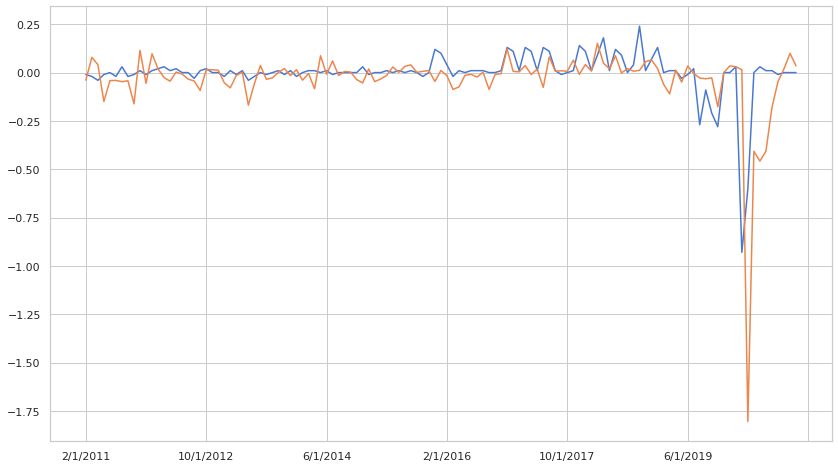

In [ ]:
result['FEDFUNDS_Actual'].plot()
result['FEDFUNDS_Predicted'].plot()

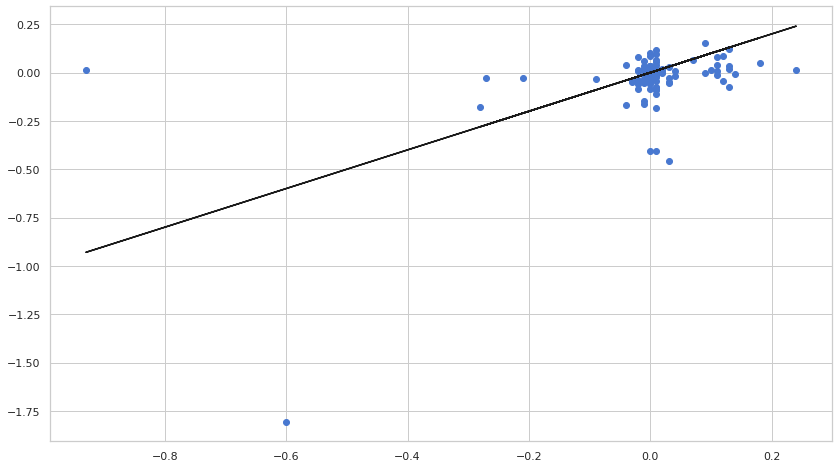

In [ ]:
plt.scatter(y_test_list, y_pred_list)
plt.plot(y_test_list, y_test_list,'k-') # identity line

In [ ]:
#Mean squared error regression loss
mean_squared_error(y[-n_forecast:], y_pred_list)

0.02980988680672267

In [ ]:
#RMSE
mean_squared_error(y[-n_forecast:], y_pred_list, squared = False)

0.1726553990083214

In [ ]:
#MAE
mean_absolute_error(y[-n_forecast:], y_pred_list)

0.07964957983193273

# Extreme Gradient Boosting


In [ ]:
#Grid Search for Optimal Hyperparameter
# pipeline
def pipeline(config):

    # unpack config
    n_trees, n_comps, learn_rate, reg_alp, reg_lamb = config

    # Steps
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components=n_comps, random_state=1)),
             ('xgboost', XGBRegressor(objective = 'reg:squarederror', booster='gbtree', n_estimators=n_trees, learning_rate=learn_rate, reg_alpha=reg_alp, reg_lambda=reg_lamb, eval_metric='rmse', use_label_encoder=False, random_state=1))
            ]

    pipeline = Pipeline(steps)

    return pipeline

In [ ]:
def walk_forward_validation(cfg):

    n_train = 477  #number of observations in the training set

    n_records = len(X)

    y_test_list = []

    y_pred_list = []

    j = 0

    for i in range(n_train, n_records):

        X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1] #each time constant size

        model = pipeline(cfg).fit(X_train, y_train)     #call pipeline -> train model

        y_pred = model.predict(X_test)  #forecast the gdp growth one time step

        y_pred_list.extend(y_pred)

        y_test_list.extend(y_test)

        j += 1

    score_rmse = metrics.mean_squared_error(y_test_list, y_pred_list, squared=False)

    print(' > %.3f' % score_rmse)

    return score_rmse

In [ ]:
# score a model, return None on failure
def repeat_evaluate(config, n_repeats=1):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(config) for _ in range(n_repeats)]
    # summarize score
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

In [ ]:
# grid search configs
def grid_search(cfg_list):
    # evaluate configs
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    # sort configs by score_acc, asc
    scores.sort(key=lambda tup: tup[1], reverse = True)
    return scores

In [ ]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    n_trees = [100]
    n_comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    learn_rate = [0.0001, 0.001, 0.01, 0.2, 0.3]
    reg_alp = [0.5]
    reg_lamb = [1]
    # create configs
    configs = list()
    for i in n_trees:
        for j in n_comps:
            for k in learn_rate:
                for l in reg_alp:
                    for m in reg_lamb:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [ ]:
# model configs
cfg_list = model_configs()

Total configs: 50


In [ ]:
#long run time
cfg_list = model_configs()
# grid search
scores = grid_search(cfg_list)
print('done')

Total configs: 50
 > 0.508
> Model[[100, 1, 0.0001, 0.5, 1]] 0.508
 > 0.466
> Model[[100, 1, 0.001, 0.5, 1]] 0.466
 > 0.218
> Model[[100, 1, 0.01, 0.5, 1]] 0.218
 > 0.296
> Model[[100, 1, 0.2, 0.5, 1]] 0.296
 > 0.340
> Model[[100, 1, 0.3, 0.5, 1]] 0.340
 > 0.508
> Model[[100, 2, 0.0001, 0.5, 1]] 0.508
 > 0.466
> Model[[100, 2, 0.001, 0.5, 1]] 0.466
 > 0.218
> Model[[100, 2, 0.01, 0.5, 1]] 0.218
 > 0.179
> Model[[100, 2, 0.2, 0.5, 1]] 0.179
 > 0.186
> Model[[100, 2, 0.3, 0.5, 1]] 0.186
 > 0.508
> Model[[100, 3, 0.0001, 0.5, 1]] 0.508
 > 0.467
> Model[[100, 3, 0.001, 0.5, 1]] 0.467
 > 0.214
> Model[[100, 3, 0.01, 0.5, 1]] 0.214
 > 0.205
> Model[[100, 3, 0.2, 0.5, 1]] 0.205
 > 0.218
> Model[[100, 3, 0.3, 0.5, 1]] 0.218
 > 0.508
> Model[[100, 4, 0.0001, 0.5, 1]] 0.508
 > 0.465
> Model[[100, 4, 0.001, 0.5, 1]] 0.465
 > 0.207
> Model[[100, 4, 0.01, 0.5, 1]] 0.207
 > 0.207
> Model[[100, 4, 0.2, 0.5, 1]] 0.207
 > 0.200
> Model[[100, 4, 0.3, 0.5, 1]] 0.200
 > 0.508
> Model[[100, 5, 0.0001, 0.5,

In [ ]:
#long run time
scores

[('[100, 3, 0.0001, 0.5, 1]', 0.5083823832930568),
 ('[100, 2, 0.0001, 0.5, 1]', 0.5082606725746388),
 ('[100, 1, 0.0001, 0.5, 1]', 0.5082222711991182),
 ('[100, 4, 0.0001, 0.5, 1]', 0.5081912282711522),
 ('[100, 9, 0.0001, 0.5, 1]', 0.5081160839761453),
 ('[100, 10, 0.0001, 0.5, 1]', 0.5081156787426551),
 ('[100, 7, 0.0001, 0.5, 1]', 0.5080571469163586),
 ('[100, 8, 0.0001, 0.5, 1]', 0.5080571469163586),
 ('[100, 5, 0.0001, 0.5, 1]', 0.5080561693013244),
 ('[100, 6, 0.0001, 0.5, 1]', 0.5080463847648881),
 ('[100, 3, 0.001, 0.5, 1]', 0.46692975241231527),
 ('[100, 2, 0.001, 0.5, 1]', 0.46602230418421314),
 ('[100, 1, 0.001, 0.5, 1]', 0.4656730689486049),
 ('[100, 4, 0.001, 0.5, 1]', 0.46548026776184215),
 ('[100, 10, 0.001, 0.5, 1]', 0.465154827555553),
 ('[100, 9, 0.001, 0.5, 1]', 0.4651307980672116),
 ('[100, 7, 0.001, 0.5, 1]', 0.46480674824257945),
 ('[100, 8, 0.001, 0.5, 1]', 0.4647516769753221),
 ('[100, 6, 0.001, 0.5, 1]', 0.46468818567968),
 ('[100, 5, 0.001, 0.5, 1]', 0.464519

In [ ]:
# Pipeline aftering determining the optimal hyperparameters

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
        ('pca', PCA(n_components= 9, random_state=1)),
        ('xgboost', XGBRegressor(objective = 'reg:squarederror', booster='gbtree', n_estimators=100,
        learning_rate= 0.2, reg_alpha= 0.5, reg_lambda= 1, eval_metric='rmse', use_label_encoder=False, random_state=1))
            ]

pipeline_final = Pipeline(steps_final)

In [ ]:
start=time.time()

n_train = 477

n_records = len(X)

y_test_list = []

y_pred_list = []

#y_prob_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    #y_prob = model.predict_proba(X_test)[:, 1]

    y_pred_list.extend(y_pred)

    #y_prob_list.extend(y_prob)

    y_test_list.extend(y_test)

    j += 1

end=time.time()

print("Running Time:", end - start)

Running Time: 13.027925491333008


In [ ]:
result = pd.DataFrame({'FEDFUNDS_Actual': y[-n_forecast:], 'FEDFUNDS_Predicted': y_pred_list}, columns=['FEDFUNDS_Actual', 'FEDFUNDS_Predicted'])
result

,FEDFUNDS_Actual,FEDFUNDS_Predicted
,,
2/1/2011,-0.01,0.652481
3/1/2011,-0.02,0.481641
4/1/2011,-0.04,0.016754
5/1/2011,-0.01,-0.228962
6/1/2011,0.00,-0.036160
7/1/2011,-0.02,0.059581
8/1/2011,0.03,0.039914
9/1/2011,-0.02,-0.124479
10/1/2011,-0.01,-0.178674


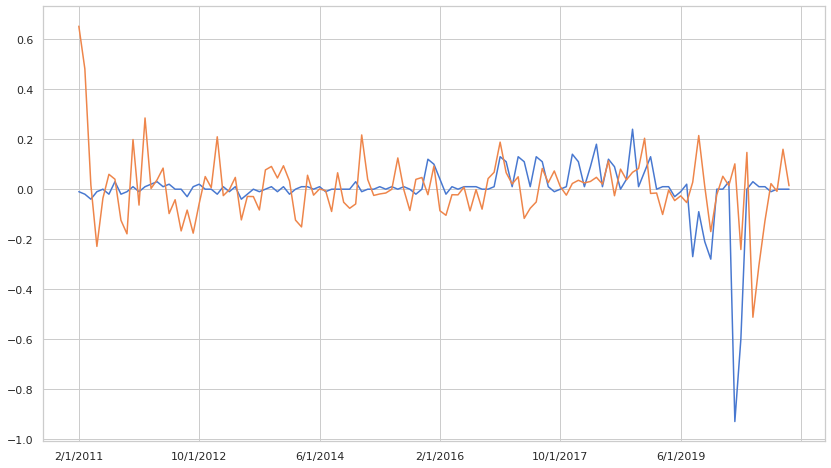

In [ ]:
result['FEDFUNDS_Actual'].plot()
result['FEDFUNDS_Predicted'].plot()

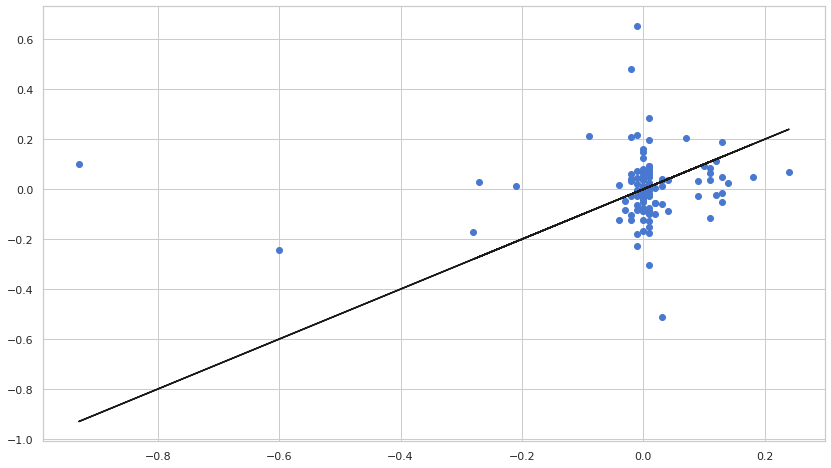

In [ ]:
plt.scatter(y_test_list, y_pred_list)
plt.plot(y_test_list, y_test_list,'k-') # identity line

In [ ]:
#Mean squared error regression loss
mean_squared_error(y[-n_forecast:], y_pred_list)

0.02925104318736915

In [ ]:
#RMSE
mean_squared_error(y[-n_forecast:], y_pred_list, squared = False)

0.17102936352383807

In [ ]:
#Mean absolute error
mean_absolute_error(y[-n_forecast:], y_pred_list)

0.10202837472202396